# 04 – Supervised Learning (Classification)

Train Logistic Regression, Decision Tree, Random Forest, and SVM. Evaluate Accuracy, Precision, Recall, F1, ROC & AUC.


Shape after cleaning: (303, 14)
Target distribution:
 target
0    164
1    139
Name: count, dtype: int64


<Figure size 800x600 with 0 Axes>

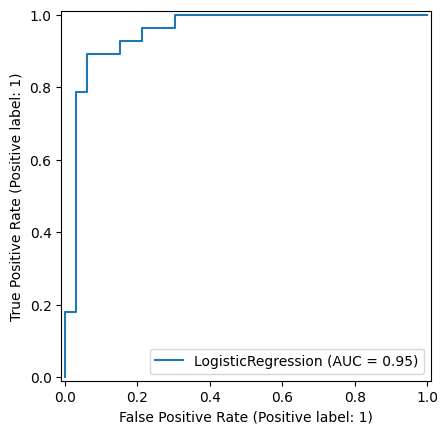

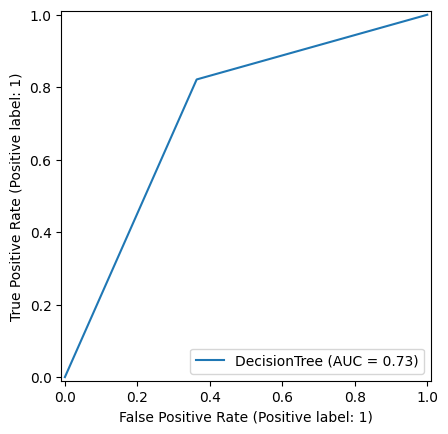

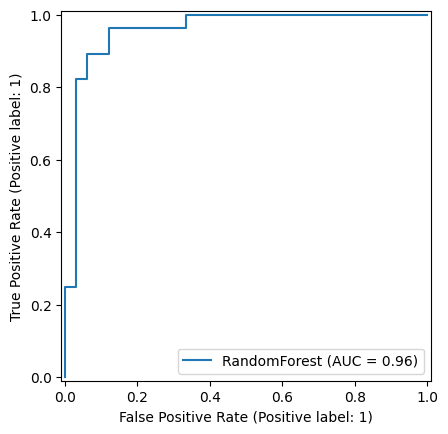

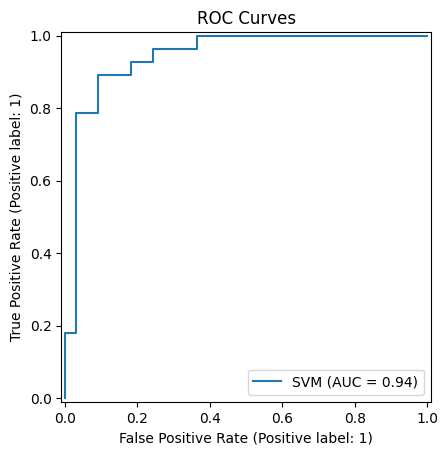

                Model  Accuracy  Precision    Recall        F1       AUC
2        RandomForest  0.901639   0.843750  0.964286  0.900000  0.957792
0  LogisticRegression  0.868852   0.812500  0.928571  0.866667  0.951299
3                 SVM  0.852459   0.806452  0.892857  0.847458  0.943723
1        DecisionTree  0.721311   0.657143  0.821429  0.730159  0.728896

Best model: RandomForest
Saved final model to ../models/final_model.pkl


In [2]:
# --- Imports ---
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from joblib import dump

# --- 1. Load and clean .data file ---
DATA_PATH = os.path.join("..", "data", "heart_disease.data")  # Adjust path if needed
df = pd.read_csv(DATA_PATH, header=None)

# Assign column names according to UCI dataset
df.columns = [
    "age","sex","cp","trestbps","chol","fbs","restecg",
    "thalach","exang","oldpeak","slope","ca","thal","num"
]

# Replace '?' with NaN and convert to numeric
df = df.replace('?', np.nan)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows where target is missing and create binary target column
df = df.dropna(subset=['num'])
df['target'] = (df['num'] > 0).astype(int)
df = df.drop(columns=['num'])

print("Shape after cleaning:", df.shape)
print("Target distribution:\n", df['target'].value_counts())

# --- 2. Split features and target ---
X = df.drop(columns=['target'])
y = df['target']

num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = [c for c in X.columns if c not in num_features]

# --- 3. Preprocessor ---
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_features)
])

# --- 4. Define models ---
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42),
    "SVM": SVC(probability=True, kernel="rbf", C=1.0, gamma="scale", random_state=42)
}

# --- 5. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 6. Train, evaluate, and plot ROC ---
results = []
plt.figure(figsize=(8,6))

for name, mdl in models.items():
    pipe = Pipeline([("prep", preprocessor), ("clf", mdl)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba)

    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)
    results.append([name, acc, prec, rec, f1, auc])

plt.title("ROC Curves")
plt.show()

# --- 7. Summarize results ---
res_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","AUC"])
print(res_df.sort_values("AUC", ascending=False))

# --- 8. Save best model ---
best = res_df.sort_values("AUC", ascending=False).iloc[0]["Model"]
print("\nBest model:", best)

# Retrain on full data using the best model
best_pipe = Pipeline([("prep", preprocessor), ("clf", models[best])])
best_pipe.fit(X, y)

os.makedirs("../models", exist_ok=True)
dump(best_pipe, os.path.join("..", "models", "final_model.pkl"))
print("Saved final model to ../models/final_model.pkl")
